# <font color="blue"> Processing Scara Robot positioning Images using CAS image processing </font>

In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import struct
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import cv2
import os

def imageShow(casTable, imageId, nimages):
    a = s.table.fetch(sastypes=False,sortby=[{'name':'_id_'}],table=casTable,to=nimages)
    fig = plt.figure(figsize=(20, 20))
    for i in range(nimages):
        imageData = a['Fetch'].iloc[ i][ imageId]
        img_np = cv2.imdecode(np.frombuffer( imageData, np.uint8),1)
        fig.add_subplot(1,nimages,i+1)
        plt.imshow(img_np)
        img_np[:,:,[0,2]]=img_np[:,:,[2,0]]
        plt.xticks([]), plt.yticks([])

# Functions which convert processed image file into a data matrix for further processing.

In [2]:
import pandas as pd
import swat.datamsghandlers as dmh

def displayImagePair(binaries, width, height, i1, i2):
    image1 = bytearray(binaries[i1])
    image1 = np.reshape(image1, (height, width))
    image2 = bytearray(binaries[i2])
    image2 = np.reshape(image2, (height, width))
    fig = plt.figure(figsize = (10, 10./height*width))
    fig.add_subplot(121)
    plt.imshow(image1)
    plt.gray()
    plt.xticks([0, width], fontsize=15)
    plt.yticks([0, height], fontsize=15)
    fig.add_subplot(122)
    plt.imshow(image2)
    plt.gray()
    plt.xticks([0, width], fontsize=15)
    plt.yticks([0, height], fontsize=15)
    plt.show()
    
def ImageBinaries2Matrix(imageBinaries, nImages, nRows, nCols):
    images = np.empty((nImages, nRows*nCols))
    for i in range(nImages):
        images[i] = bytearray(imageBinaries[i])
    return images

def Matrix2CASTable(casSession, tableName, matrix, baseColName="c"):
    nRows, nCols = matrix.shape
    baseColName = baseColName.strip()
    colNames = [baseColName + str(i) for i in range(1, nCols + 1)]
    df = pd.DataFrame(matrix, columns=colNames)
    handler = dmh.PandasDataFrame(df)
    casSession.addtable(table=tableName.strip(), replace=True, **handler.args.addtable)
    
def CASTable2Matrix(casSession, tableName, fromRow, nRows, nCols, baseColName="c"):
    fetchedTable = casSession.fetch(table=tableName, sastypes=False, From=fromRow, to=fromRow+nRows-1)['Fetch']
    baseColName = baseColName.strip()
    colNames = [baseColName + str(i) for i in range(1, nCols + 1)]
    matrix = np.zeros((nRows, nCols))
    for i in range(nCols):
        matrix[:, i] = fetchedTable[colNames[i]]
    return matrix

import os,time
def get_information(directory):
    file_list = []
    for i in os.listdir(directory):
        a = os.stat(os.path.join(directory,i))
        file_list.append([i,time.ctime(a.st_mtime),time.ctime(a.st_ctime)]) #[file,most_recent_access,created]
    return file_list

In [3]:
s = CAS('centis', 5570, 'sasdemo', 'SASpw1')
s.loadactionset('image')

NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.0212s, user: 0.00218s, sys: 0.0168s, mem: 0.195mb

In [4]:
res_robotlib = s.table.addCaslib(dataSource={"srcType":"PATH"}, name="robot", path="/home/sasdemo/robotdata")
res_imagelib = s.table.addCaslib(dataSource={"srcType":"PATH"}, name="images", path="/home/sasdemo/pictures")

NOTE: 'robot' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'robot'.
NOTE: 'images' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'images'.


In [5]:
s.image.loadImages(casout={"caslib":"robot", "name":"RobotImages", "replace":True}, caslib="images", path="")
imageTable = s.CASTable(caslib="robot", name="RobotImages")
imageTable.head()

NOTE: Loaded 132 images from /home/sasdemo/pictures/ into Cloud Analytic Services table RobotImages.


,_image_,_size_,_path_,_type_,_id_
0,b'\xff\xd8\xff\xe1d\x18Exif\x00\x00MM\x00*\x00...,180072,/home/sasdemo/pictures/66_000_1548341378.96097...,jpg,1
1,b'\xff\xd8\xff\xe1d\x18Exif\x00\x00MM\x00*\x00...,180079,/home/sasdemo/pictures/66_010_1548341384.45301...,jpg,2
2,b'\xff\xd8\xff\xe1d\x18Exif\x00\x00MM\x00*\x00...,180206,/home/sasdemo/pictures/66_020_1548341389.94967...,jpg,3
3,b'\xff\xd8\xff\xe1d\x18Exif\x00\x00MM\x00*\x00...,179927,/home/sasdemo/pictures/66_030_1548341395.43971...,jpg,4
4,b'\xff\xd8\xff\xe1d\x18Exif\x00\x00MM\x00*\x00...,179296,/home/sasdemo/pictures/66_040_1548341400.95973...,jpg,5


NOTE: The CONTOURS function accepts only images with one channel.
NOTE: Table ROBOTIMAGES contains compressed images.
NOTE: 132 out of 132 images were processed successfully and saved as compressed images to the Cloud Analytic Services table resultingRobotImages.


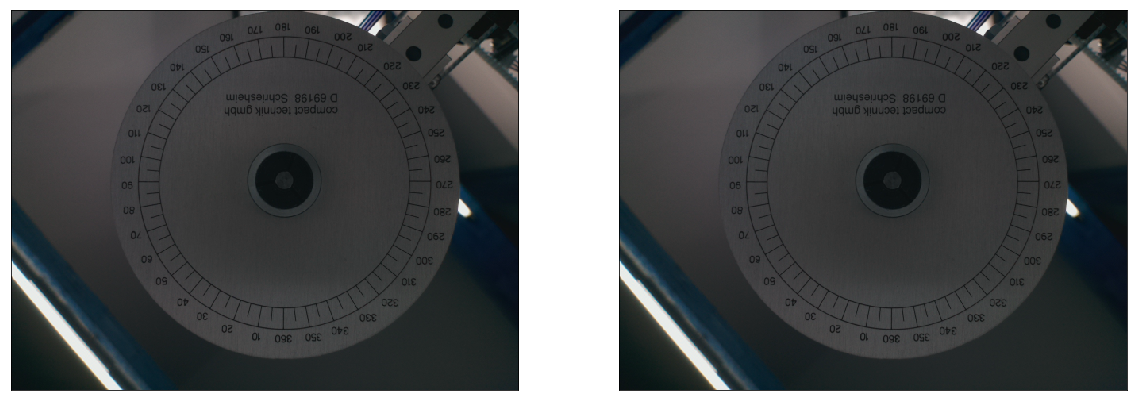

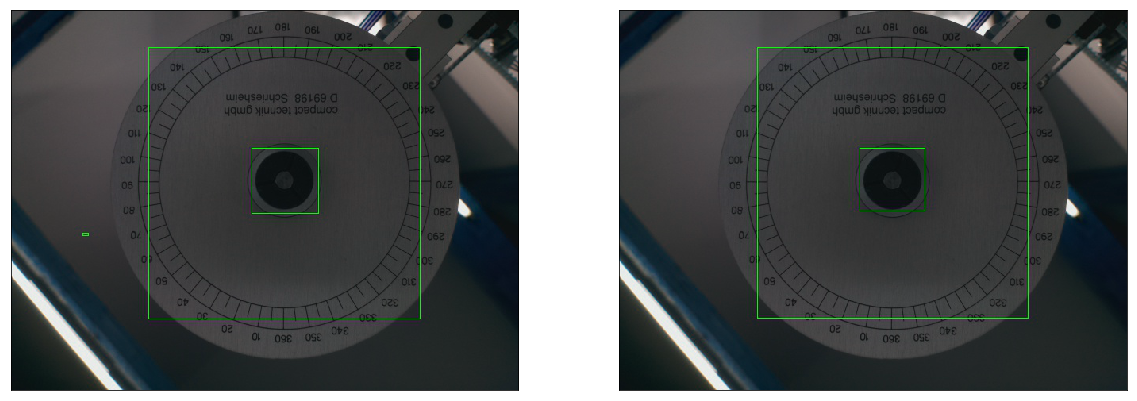

In [6]:
#functionType": "ADD_CONSTANT" | "BILATERAL_FILTER" | "BOX_FILTER" | "BUILD_PYRAMID" | "CANNY_EDGE" | "CONTOURS" | 
#               "CONVERT_COLOR" | "CUSTOM_FILTER" | "GAUSSIAN_FILTER" | "GET_PATCH" | "HIST_EQUALIZATION" | "LAPLACIAN" |
#               "LINEAR_TRANSFORMATION" | "MEDIAN_FILTER" | "MORPHOLOGY" | "MUTATIONS" | "NORMALIZE" | "RESCALE" | "RESIZE" | 
#               "SOBEL" | "THRESHOLD" 
imageShow(imageTable, 0, 2)
r = s.image.processImages(casout={"caslib":"robot", 'name':'resultingRobotImages','replace':True}, 
        imagetable={"caslib":"robot", 'name':'RobotImages'},
        imageFunctions=[
                        #change color space, required by the bounding box computation
                        {'options':{'functiontype':'CONVERT_COLOR', 'type':'COLOR2GRAY'}}, 
                         #edge detection with the Laplace operator
                        {'options':{'functiontype':'LAPLACIAN', 'kernelsize':2.5}},
                        #contour detection and drawing
                        {'options':{'functiontype':'CONTOURS', 'boundingbox':True,'approximate':True,'groupboxes':True}}
                        ])
outTable = s.CASTable(caslib="robot", name='resultingRobotImages')
imageShow(outTable, 0, 2)

In [7]:
print(outTable.head())
outTable.columninfo()

Selected Rows from Table RESULTINGROBOTIMAGES

                                             _image_  _size_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   69026   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   67572   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   67450   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   67622   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   69648   

                                              _path_ _type_  _id_  
0  /home/sasdemo/pictures/76_050_1548343139.03783...    jpg   116  
1  /home/sasdemo/pictures/76_060_1548343144.52286...    jpg   117  
2  /home/sasdemo/pictures/76_070_1548343149.99010...    jpg   118  
3  /home/sasdemo/pictures/76_080_1548343155.47416...    jpg   119  
4  /home/sasdemo/pictures/76_090_1548343160.96423...    jpg   120  


,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,varbinary,79926,79926,0,0
1,_size_,2,int64,8,12,0,0
2,_path_,3,varchar,52,52,0,0
3,_type_,4,char,3,3,0,0
4,_id_,5,int64,8,12,0,0


In [139]:
# Identify number of images and Image Resolution for futher processing
ImageSummary=s.image.summarizeImages(table={"caslib":"robot", 'name':'resultingRobotImages'})
print(ImageSummary)
print("Summary Keys are ", ImageSummary.keys())
pdImageSummary = pd.DataFrame(data=ImageSummary.Summary)

nImages = int(pdImageSummary.loc[0,"jpg"])
print("Number of Images =",nImages)
width = int(pdImageSummary.loc[0,"minWidth"])
print("Width =",width)
height = int(pdImageSummary.loc[0,"minHeight"])
print("Height =",height)

NOTE: Table RESULTINGROBOTIMAGES contains compressed images.
NOTE: 132 out of 132 images were scanned and results were saved to the summary table.
[Summary]

     Column    jpg  minWidth  maxWidth  minHeight  maxHeight  meanWidth  \
 0  _image_  132.0     640.0     640.0      480.0      480.0      640.0   
 
    meanHeight  mean1stChannel  min1stChannel  max1stChannel  mean2ndChannel  \
 0       480.0       52.429822            0.0          255.0       56.232936   
 
    min2ndChannel  max2ndChannel  mean3rdChannel  min3rdChannel  max3rdChannel  
 0            0.0          255.0        56.18118            0.0          255.0  

+ Elapsed: 0.224s, user: 0.898s, sys: 0.0881s, mem: 1.07mb
Summary Keys are  odict_keys(['Summary'])
Number of Images = 132
Width = 640
Height = 480


In [140]:
s.image.flattenImageTable(
    casout={"caslib":"robot", 'name':'flattenedRobotImages'},
    table={"caslib":"robot", 'name':'resultingRobotImages'},
    w = width,
    h = height,
    groupChannels = True
)

NOTE: Table RESULTINGROBOTIMAGES contains compressed images.


ERROR: The table flattenedRobotImages already exists in the session.
ERROR: The action stopped due to errors.


+ Elapsed: 0.764s, user: 0.332s, sys: 0.432s, mem: 437mb

In [141]:
flattenedImageTable = s.CASTable(caslib="robot", name='flattenedRobotImages')

In [144]:
flattenedImageTableGreen = flattenedImageTable.loc[:, int((width*height)+1):int((2*width*height)+1)]

In [145]:
hlp = flattenedImageTableGreen.fetch(from_=1,to=1)

In [147]:
type(hlp)
#type(hlp3)
#index = list(range(int(nImages)))
hlp2 = pd.DataFrame(data=hlp)
#print(hlp3)
#type(hlp3)
#for i in range(int(nImages)):
#    print(i)
#hlp=flattenedImageTable.loc[1, 1]
#print(hlp)
#hlp2 = hlp.as_matrix([2, 2])

ValueError: If using all scalar values, you must pass an index

In [79]:
type(hlp)

swat.cas.results.CASResults

In [67]:
flattenedImageTableGreen = flattenedImageTable.loc[:, idx[:, '_path_'], int((width*height)+1):int((2*width*height)+1)]
flattenedImageTableGreen.head()

NameError: name 'index' is not defined

In [58]:
flattenedImageTableGreen.fetch(fetchVars=["_path_"])

ERROR: Parameter 'fetchvars' was specified more than once.
ERROR: The action stopped due to errors.


+ Elapsed: 0.000134s, user: 117s, sys: 54.2s

In [18]:
print(type(flattenedImageTable))
result = s.table.recordCount(table={"caslib":"robot", 'name':'flattenedRobotImages'})
nrow = result[0,"N"]

print(nrow)

<class 'swat.cas.table.CASTable'>


KeyError: (0, 'N')

In [8]:
fetchedImages=s.fetch(table={"caslib":"robot", 'name':'resultingRobotImages'}, sastypes=False, sortBy="_path_",
                      fetchVars={"_path_", "_image_"}, to=nImages)['Fetch']
imageBinaries=fetchedImages["_image_"]
type(imageBinaries[1])

bytes

In [90]:
images = np.empty((nImages, height*width),dtype=np.int64)
#for i in range(nImages):
#    images[i] = bytearray(imageBinaries[i])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [9]:
ImageMatrix = ImageBinaries2Matrix(imageBinaries, nImages, height, width)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [13]:
#outTable.slice(1,1)
#outTable.numrows()
#imageMatrix = ImageBinaries2Matrix(outTable, 132, 100, 100)


NameError: name 'ImageBinaries2Matrix' is not defined

In [69]:
s.image.extractDetectedObjects(
    casOut={"caslib":"robot", 'name':'resultingRobotImagesVisualized', 'replace':True},
    table={"caslib":"robot", 'name':'resultingRobotImages'},
    coordType="RECT"
)

ERROR: There is an issue with the required columns: either _nObjects_ is missing or object detection columns. The maxObjects parameter would be more than the maximum number of objects detected too.
ERROR: The action stopped due to errors.


+ Elapsed: 0.0016s, sys: 0.00174s, mem: 0.261mb

In [15]:
s.terminate()